# Introdução

Nesta atividade vamos seguir aproximadamente o material do livro-texto da disciplina (Géron, capítulo 2), e o notebook do material de suporte do livro em https://github.com/ageron/handson-ml .

Sua missão é prever o valor mediano de imóveis em distritos residenciais da Califórnia, baseado em algumas características.

O conjunto de dados vem do censo de 1990 da Califórnia: preços hoje em dia estão radicalmente diferentes!

# Entendendo o problema

Antes de começar a trabalhar no problema, tente entender o contexto no qual o problema se insere. Por que desejamos prever os preços medianos dos imóveis? No livro, o autor menciona que neste exemplo fictício estamos desenvolvendo um preditor de preços medianos como um subsistema de um sistema de auxílio à tomada de decisão em investimentos imobiliários. 

No livro, o autor também menciona que o sistema atual da empresa usa estimativas manuais, com um erro de cerca de 15%. Um sistema de machine learning pode, potencialmente, ser mais barato, mais rápido e mais preciso!

Você consegue pensar em outros motivos?

**R:**
<i>Podemos utilizar machine learning para evitar que as previsões sejam preconceituosas no futuro. O algoritmo será tão preconceituoso quanto os dados passado para ele.</i> <br>
<i>Um algoritmo de machine learning pode ser usado em situações em que um humano não pode estar presente. Como por exemplo em uma sonda espacial. Ela estará em um ambiente inospito para um ser humano, mas o algoritmo pode funcionar normalmente.</i><br>
<i>O algoritmo consegue funcionar 24/7, sem descanso. Diferentemente de um ser humano que não consegue trabalhar tanto.</i><br>
<i>O sistema é replicável e armazenável.</i>

Que tipo de problema temos aqui, do ponto de vista de machine learning:

- Aprendizado supervisionado ou não-supervisionado?

- Classificação ou regressão?

**R:** <i>Regressão supervisionada, pois queremos prever um valor de uma entrada futura com base em informações passadas.</i>


Agora, selecione a medida de desempenho do seu sistema de machine learning. É importante escolher a medida de performance antes de trabalhar com o problema, para que essa escolha seja idônea. Se deixarmos a escolha para mais tarde, depois de conhecer nossos dados em detalhe, pode ser que sejamos tentados a escolher a medida de performance que nos pareça mais favorável para exibir um "bom" desempenho! Isso não é ciência!

Neste problema vamos escolher a raiz quadrada do erro médio quadrático como medida de erro (RMSE - Root Mean Squared Error). Sejam $X = (x_1, x_2, \cdots, x_m)$  e $y = (y_1, y_2, \cdots, y_m)$ nossos conjuntos de testes, onde 

- $X$ contém as características dos distritos e

- $y$ contém os valores medianos de imóveis nos correspondentes distritos. 

Seja também $h(x)$ o nosso modelo preditivo de valores medianos de imóveis, que foi obtido através de ajuste (fit) de modelo à partir das amostras de treinamento.

Então RMSE é dado por:

$$\text{RMSE}(X, y, h) = \sqrt{\frac{1}{m} \sum_{i=1}^{m}\left(h(x_i) - y_i\right)^{2}}$$

Pergunta: por que elevar ao quadrado? Por que aplicar a raiz quadrada?

**R:**<i>Elevamos os valores ao quadrado para que todos sejam positivos, assim um erro negativo não anulará um erro positivo. Aplicamos a raiz quadrada para voltar para a escala e unidade de medida original.</i>


# Inicializando o código

Na maioria dos nossos trabalhos vamos usar as bibliotecas:

- Pandas: uma biblioteca para análise de dados em Python. https://pandas.pydata.org/

- NumPy: computação científica em Python. http://www.numpy.org/

- Matplotlib: para gráficos e outras visualizações

Atenção: mais adiante vamos acabar inevitavelmente misturando o uso de duas estruturas de armazenamento de dados em tabelas: DataFrames (Pandas) e ndarrays (NumPy), fique atento!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Vamos fixar a semente do gerador de números aleatórios, para ter reproducibilidade neste notebook. 

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Carregando dados

No livro o autor descreve a necessidade da automação no processo de adquirir e armazenar dados. Isso é muito importante sim! Para simplificar o trabalho de hoje vamos pular esta etapa, e carregar diretamente o arquivo de dados fornecido pelo professor, mas recomendo a leitura e reflexão acerca do material do livro. Afinal, são dicas valiosas de quem esteve "nas trincheiras", e eu assino embaixo das dicas dele.

Por ora vamos apenas carregar o arquivo CSV:

In [3]:
HOUSING_FILE = "housing.csv"


def load_housing_data(housing_file=HOUSING_FILE):
    return pd.read_csv(housing_file)


housing = load_housing_data()

A função retorna um DataFrame do Pandas:

In [4]:
type(housing)

pandas.core.frame.DataFrame

Um DataFrame é uma tabela com linhas e colunas nomeadas (opcionalmente), e contém vários métodos para indexação, slicing, estatísticas, e muito mais. https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

# Entendendo inicialmente os dados

Cada linha da tabela representa um distrito da Califórnia. Vamos conhecer mais sobre os dados:

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [6]:
housing.head(n=10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


Perguntas:

- Quantos distritos existem na base?

- Qual é a coluna de valores dependentes?

- Tem valor faltante?

- O que representam as colunas "total_rooms", "total_bedrooms", e "households"?

**R:** <i>
- Há 20640 distritos na base.
- A coluna dependente é a coluna "median_house_value", pois podemos a prever com base nas anteriores.
- Existe 167 valores NULL na coluna "total_bedrooms".
- "total_rooms" e "total_bedrooms" são respectivamente o número total de comodos e de quartos em todo o distrito. Já "households" é o total de casas naquele distrito.
    </i>

Para ganhar um entendimento melhor da distribuição dos dados:

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Note que a coluna "ocean_proximity" não aparece aqui, pois trata-se de uma coluna não-numérica. Apenas as colunas numéricas estão presentes, e a coluna "ocean_proximity" indica rótulos - trata-se de dados categóricos. 

Para analisar colunas com dados categóricos, podemos usar o método ``value_counts()`` na *série* associada à coluna de interesse:

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
type(housing["ocean_proximity"])

pandas.core.series.Series

Se as estatisticas descritivas sumárias do método ``describe()`` não são suficientes para se obter uma visão dos dados, tente histogramas:

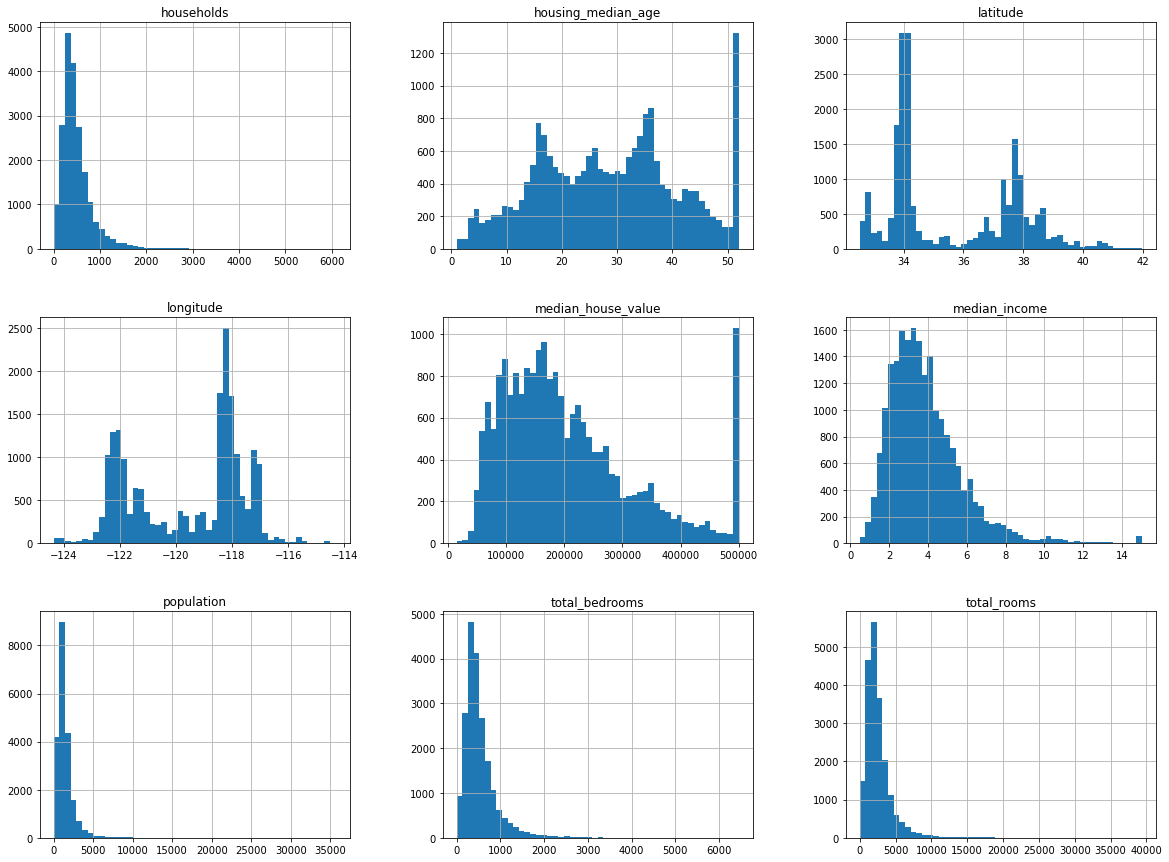

In [10]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

Perguntas:

- Notou alguma anomalia? Qual? Por que você acha que isso aconteceu?

- Quais são as unidades de medida de cada coluna?

- Este dataset tem um problema sério: o preço mediano dos imóveis foi artificialmente limitado em 500k. Talvez no formulário de pesquisa de dados tivesse uma opção, na seção "Preço do imóvel", onde estava escrito "mais de 500k". Como garantir que o sistema funcionará para prever preços acima de 500k?

**R:** <i>
- Há anomalias nos histogramas das colunas "housing_median_age" e "median_house_value". Há um acumulo de valores nos valores mais altos do histograma. Isso se deve ao fato do dataset ter sido construido com a opção "maior que tal valor", fazendo com que todos os valores acima se acumulassem em um só.
- São respectivamente: Sem unidade (contagem), anos, graus, graus, dolares, milhares de dolares anuais, sem unidade (contagem), sem unidade (contagem) e sem unidade (contagem).
- Não dá para garantir.
    </i>

***PARE!***

Antes de prosseguir, devemos dividir nossos dados em duas partes: conjunto de treinamento e de testes! *E devemos jurar solenemente que jamais vamos explorar o conjunto de testes, devemos utilizá-lo apenas para as medidas finais de desempenho do nosso sistema!*

Tal medida se faz necessária para evitar overfitting, mesmo sem querer! Pode ser que observemos algum padrão nos dados de teste e incorporemos este padrão (inconscientemente) nas nossas decisões de projeto do modelo de machine learning. Então nosso resultado final será otimista demais, e nosso sistema não terá um desempenho tão bom em produção. À esse tipo de viés induzido por ter "espiado" os dados de teste chamamos ****data snooping bias****

# Dividindo os dados em conjunto de treinamento e de testes

Para selecionar um conjunto de testes, basta escolher aleatoriamente algumas amostras do conjunto original. Tipicamente selecionamos 20% da amostra para testes. Os demais pontos de dados serão o conjunto de treinamento.

Isto pode ser feito com Scikit-Learn usando a função ``train_test_split()``:

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=RANDOM_SEED)

In [12]:
train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0,<1H OCEAN
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,97800.0,INLAND
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,222100.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN


In [13]:
X_train = train_set.drop(columns=["median_house_value"])
y_train = train_set["median_house_value"]

In [14]:
train_set.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924485,-0.101818,0.038676,0.063064,0.094276,0.049306,-0.017040,-0.046349
latitude,-0.924485,1.000000,0.005296,-0.029224,-0.059998,-0.102499,-0.064061,-0.076571,-0.142983
housing_median_age,-0.101818,0.005296,1.000000,-0.360922,-0.320624,-0.292283,-0.302796,-0.121711,0.103706
total_rooms,0.038676,-0.029224,-0.360922,1.000000,0.930489,0.857936,0.920482,0.198268,0.133989
total_bedrooms,0.063064,-0.059998,-0.320624,0.930489,1.000000,0.878932,0.980255,-0.009141,0.047980
population,0.094276,-0.102499,-0.292283,0.857936,0.878932,1.000000,0.907452,0.004122,-0.026032
households,0.049306,-0.064061,-0.302796,0.920482,0.980255,0.907452,1.000000,0.012776,0.063714
median_income,-0.017040,-0.076571,-0.121711,0.198268,-0.009141,0.004122,0.012776,1.000000,0.690647
median_house_value,-0.046349,-0.142983,0.103706,0.133989,0.047980,-0.026032,0.063714,0.690647,1.000000


In [15]:
print("{} train + {} test".format(len(train_set), len(test_set)))

16512 train + 4128 test


Normalmente isso basta.

Porém, o livro tece várias considerações de natureza prática a respeito de como fazer uma boa separação entre conjuntos de treinamento e teste. Em particular:

- Separação por valor de hash: quando estamos em um ambiente onde o conjunto de dados cresce a cada dia (como no caso do autor do livro, que era do time de machine learning do YouTube), é importante ter uma política de seleção de dados de teste que não permita que itens de teste migrem para o conjunto de treinamento ao se fazer uma nova amostragem dos dados.

- Separação estratificada: quando é importante garantir representatividade proporcional aproximadamente igual nos conjuntos de treinamento e teste, em relação a algum atributo, devemos usar separação estratificada. Por exemplo: se queremos dividir um grupo de pacientes em um experimento entre conjuntos de controle e de tratamento, devemos usar separação estratificada em relação ao sexo dos participantes.

O código abaixo faz separação estratificada em relação à uma variável categórica inventada que se relaciona com a renda média:

In [16]:
# Constroi uma coluna nova com categorias de renda fictícias.
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)


# Divide, de modo estratificado, o conjunto de dados.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [17]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [18]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [19]:
# Remove a coluna nova, que foi adicionada apenas temporariamente.
strat_train_set.drop(["income_cat"], axis=1, inplace=True)
strat_test_set.drop(["income_cat"], axis=1, inplace=True)

In [20]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


In [21]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 5241 to 2398
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           4128 non-null   float64
 1   latitude            4128 non-null   float64
 2   housing_median_age  4128 non-null   float64
 3   total_rooms         4128 non-null   float64
 4   total_bedrooms      4079 non-null   float64
 5   population          4128 non-null   float64
 6   households          4128 non-null   float64
 7   median_income       4128 non-null   float64
 8   median_house_value  4128 non-null   float64
 9   ocean_proximity     4128 non-null   object 
dtypes: float64(9), object(1)
memory usage: 338.6+ KB


A partir de agora usaremos os conjuntos strat_train_set e strat_test_set. O conjunto strat_train_set será usado para várias explorações e para construir nosso modelo preditivo. O conjunto strat_test_set será usado só no final do projeto, para avaliar a performance final do nosso modelo.

# Explorando melhor os dados de treinamento

Nossa missão agora é construir um modelo preditivo à partir dos exemplos do conjunto de treinamento. Para isso, devemos:

- Visualizar e explorar os dados para entendê-los melhor

- Preparar os dados para machine learning

- Escolher uma boa família de modelos

- Treinar os modelos, fazer ajuste fino dos hiperparâmetros.

Para explorar os dados é recomendável que você separe um pedaço do conjunto de treinamento para explorar. O motivo é prático: fica mais rápido iterar sobre os dados, visualizar, etc! Como este dataset é minúsculo (para os padrões de machine learning), vamos explorar o conjunto de treinamento inteiro mesmo.

In [22]:
housing = strat_train_set.copy()

### Dados geográficos

Vamos visualizar os dados geográficos, para começar:

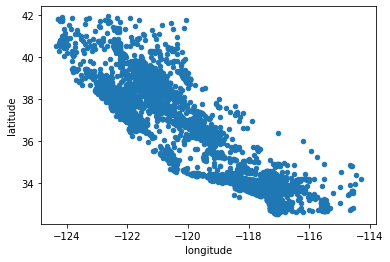

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

Como temos muitos dados agrupados, fica difícil distinguir a real densidade de pontos.

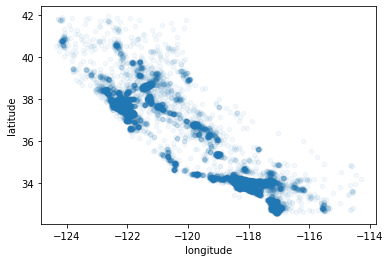

In [24]:
housing.plot(
    kind="scatter", x="longitude", y="latitude", alpha=0.05
)  # Teste vários valores de alpha.
plt.show()

Opa, agora melhorou!

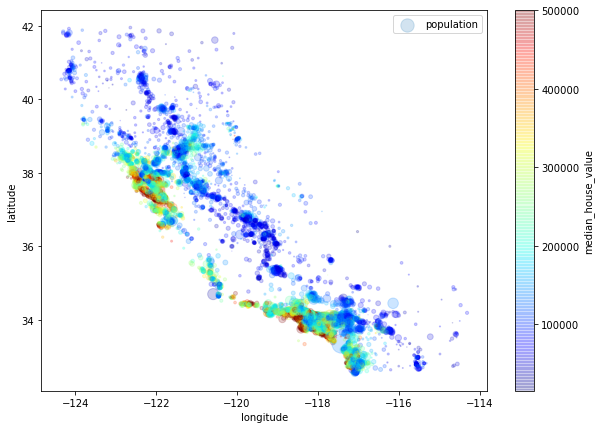

In [25]:
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    s=housing["population"] / 100,
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    label="population",
    figsize=(10, 7),
    alpha=0.2,
    sharex=False,
)
plt.legend()
plt.show()

Muito melhor! Agora parece que a localização do distrito impacta bastante o preço mediano! Nossa intuição já dizia que esta informação era valiosa, a visualização ajuda a confirmar.

### Correlação entre variáveis

A simples correlaçao linear (correlação de Pearson, ou valor R) entre a variável dependente e cada uma das variáveis independentes já pode ser um bom indicador da chance de sucesso do nosso futuro modelo preditivo.

Já a correlação entre variáveis independentes pode indicar que temos variáveis "repetitivas" no nosso conjunto de dados, e isso pode diminuir o desempenho do nosso modelo preditivo.

Observe que estamos olhando apenas para correlação linear, o tipo mais simples de correlação. Para medir relacionamentos não-lineares, existem várias outras medidas de correlação não-linear:

- Correlação de postos (rank correlation): correlação de Spearman, correlação $\tau$ de Kendall. Ambos estão implementados no método ``corr()`` dos DataFrames do Pandas (o default é Pearson).

- Informação mútua e outras medidas de teoria da informação

- entre outras!

Trata-se de uma área fértil da estatística.

Pergunta (para casa):

- O que são as correlações de Spearman e Kendall?

**R:** <i>
A correlação de Spearman avalia a relação monotônica entre as variaveis, ou seja, se quando uma cresce a outra também cresce, porém sem se importar fortemente com a taxa desse crescimento, o importante é que as duas cresçam ou decresçam juntas, sem demonstrar o comportamente contrário. <br>
A correlação de Kendall avalia a relação entre o ranqueamento entre as variaveis. Isso verifica se o maior valor de uma coluna está ligado ao maior valor da coluna de comparação e assim por diante. Um coeficiente 1 significa que ambas possuem o mesmo ordenamento enquanto valores menores indicam uma falha nesse ordenamento.
</i>

In [26]:
correlation_matrix = housing.corr()

In [27]:
correlation_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


Perguntas:

1. Observe que a diagonal da matrix de correlação contém apenas valores 1.0. Por que?

2. Explique o significado das seguintes correlações:

    2.1. "population" vs "households"
    
    2.2. "households" vs "total_rooms" e "households" vs "total_bedrooms"
    
    2.3. "median_house_value" vs "median_income"
    
    2.4. "population" vs "median_income"
    
    2.5. "latitude" vs "longitude". Seria similar no Chile? E na cidade de São Paulo? E no Brasil como um todo?

**R:**
- Pois estão comparando a variavel com ela mesma.
- Explicando correlações
    - 2.1 Quanto maior a população local, maior o número de imóveis necessários na região.
    - 2.2 Quanto maior o número de imóveis, maior o número de comodos totais de imóveis. Da mesma forma que quanto maior o número de imóveis, maior é o número de quartos.
    - 2.3 Quando maior a renda de uma pessoa, maior será o valor do imóvel onde ela vive.
    - 2.4 A quantidade de pessoas em uma mesma região, nada nos diz a respeito da renda dessas pessoas.
    - 2.5 Não seria similar nesses locais, essa correlação existe por conta do formato do estado da California. Mudando o formato da região analisada essa correlação mudaria.

Ok, mas o que a gente quer é saber: quais variáveis independentes podem nos ajudar a prever a variável dependente? Vamos nos concentrar na coluna "median_house_value":

In [28]:
correlation_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Em resumo: como dizemos na gíria de ciência dos dados - parece que tem sinal ai!

# Preparando os dados para o modelo

Estamos agora mais encorajados a construir um modelo de machine learning para nosso problema: nossa investigação mostrou a existência de sinal, e não apenas ruído.

Temos agora que preparar nossos dados e nosso modelo:

- Separar a variável dependente das variáveis independentes

- Resolver o problema dos valores faltantes na coluna "total_bedroom"

- A maioria dos modelos de machine learning lida com variáveis numéricas apenas. Temos que fazer algo em relação à variável categórica "ocean_proximity"

- Adicionar outras transformações: criar características extras que podem ser úteis, reescalar características, etc.

## Separando X e y

In [29]:
# Variáveis independentes: dataset original menos a coluna de valores dependentes.
housing = strat_train_set.drop("median_house_value", axis=1)

# Variável dependente, também chamada de label.
housing_labels = strat_train_set["median_house_value"].copy()

## Resolvendo o problema dos valores faltantes

Como percebemos antes, estão faltando alguns valores na coluna "total_bedrooms":

In [30]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


Bom, temos 3 alternativas:

- Remover a coluna inteira de dados faltantes, ou

- Remover as linhas onde estão faltando dados, ou

- Preencher os buracos

Vamos adotar esta última estratégia. (As outras duas ficam como exercício para vocês.) Qual o valor ideal para usar aqui? Novamente, temos algumas opções:

- Preenche com zeros

- Treinar um modelo de machine learning para prever os valores desta coluna e usar o modelo para preencher os espaços! Trata-se de uma forma mais sofisticada de interpolação.

- Usar alguma estatística do dataset, como a mediana

O mais simples e realista é adotar a mediana, é o que vamos fazer então. Scikit-Learn tem uma classe especial de transformadores de dados que serve exatamente para isso, chamada ``SimpleImputer``:

In [31]:
# Cria um imputer que substitui células inválidas (NaN) pela mediana dos valores da coluna à qual a célula pertence.
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# Antes de treinar o SimpleImputer, remover a coluna de dados categóricos. O dataset resultante tem apenas
# as variáveis independentes numéricas.
housing_num = housing.drop("ocean_proximity", axis=1)

# Agora treinar o Imputer. Isto vai causar o cálculo da mediana de cada coluna,
# que ficará armazenado no Imputer para uso futuro.
imputer.fit(housing_num)

# O Imputer agora tem as estatísticas desejadas armazenadas.
print("Estatísticas do Imputer:")
print(imputer.statistics_)

# Compare com as medianas do DataFrame:
print("Medianas")
print(housing_num.median().values)

Estatísticas do Imputer:
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
Medianas
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


Agora que temos o Imputer para preencher os buracos, vamos usá-lo.

In [32]:
# Aplicar o Imputer aos nossos dados. O valor de retorno é um ndarray do NumPy.
temp = imputer.transform(housing_num)
print(type(temp))

# Trabalhar com DataFrames geralmente é mais legal - dá para referenciar colunas por nome, ao invés de indices.
# Vamos transformar o ndarray em DataFrame.
housing_tr = pd.DataFrame(temp, columns=housing_num.columns)
print(type(housing_tr))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


Verificando se os buracos foram preenchidos:

In [67]:
housing_tr[housing_tr.isnull().any(axis=1)].head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


Ótimo, não tem mais buraco!

## Codificando variáveis categóricas

A maioria dos algoritmos de machine learning trabalha apenas com variáveis numéricas, mas a coluna "ocean_proximity" tem strings, representando categorias. Como proceder?

Uma forma de abordar este problema é converter as categorias em inteiros. Isto pode ser feito usando a classe ``OrdinalEncoder`` do Scikit-Learn 0.20 (o livro está desatualizado):

In [34]:
# Separar apenas as variáveis categóricas (neste caso temos apenas uma).
housing_cat = housing[["ocean_proximity"]]
print(type(housing_cat))
print(housing_cat.head())

<class 'pandas.core.frame.DataFrame'>
      ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN


In [35]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [36]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Para alguns problemas isso pode ser uma abordagem válida. Porém, na maioria dos casos isso não serve, pois gera uma hipótese implícita de que as categorias são ordenáveis, e que podemos somar e subtrair valores de categorias!

A abordagem mais comum para a codificação de variáveis categóricas é convertê-las em uma representação vetorial, onde cada dimensão corresponde a uma categoria, e os valores em cada dimensão podem valer apenas zero ou um. Mais ainda, apenas uma dimensão valerá um, as demais valem zero. À esta representação chamamos 'one-hot encoding', por analogia com o mecanismo de sinalização em circuitos elétricos no qual apenas um fio está energizado por vez (one-hot).

No nosso problema temos cinco categorias: ``'<1H OCEAN'``, ``'NEAR OCEAN'``, ``'INLAND'``, ``'NEAR BAY'`` e ``'ISLAND'``. Então vamos associar a categoria de um distrito a um vetor de dimensão 5, com valor um na dimensão correspondente à categoria do objeto, e zero no resto. 

Por exemplo, se o distrito tem categoria ``'NEAR OCEAN'``, transformamos esta informação no vetor ``(0, 1, 0, 0, 0)``. (Assumindo que as dimensões deste vetor correspondem às categorias na mesma ordem listada no parágrafo anterior.)

No Scikit-Learn, a class OneHotEncoder recebe uma variável categórica qualquer (inteiros ou strings) e aplica a codificação one-hot.

In [37]:
# Cria o codificador.
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories="auto")

# Aprende a codificação e já aplica a mesma ao dataset fornecido. Todo transformador no sklearn
# tem os métodos fit() para aprender a transformação, e transform() para aplicá-la.
# O método fit_transform() faz os dois atos em sequência.
housing_cat_1hot = encoder.fit_transform(housing_cat)

# O resultado da codificação é uma matriz esparsa em NumPy.
print(housing_cat_1hot)

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 4)	1.0
  (3, 1)	1.0
  (4, 0)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 1)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 1)	1.0
  (12, 0)	1.0
  (13, 1)	1.0
  (14, 1)	1.0
  (15, 0)	1.0
  (16, 3)	1.0
  (17, 1)	1.0
  (18, 1)	1.0
  (19, 1)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 1)	1.0
  (24, 1)	1.0
  :	:
  (16487, 1)	1.0
  (16488, 1)	1.0
  (16489, 4)	1.0
  (16490, 3)	1.0
  (16491, 0)	1.0
  (16492, 3)	1.0
  (16493, 1)	1.0
  (16494, 1)	1.0
  (16495, 0)	1.0
  (16496, 1)	1.0
  (16497, 3)	1.0
  (16498, 1)	1.0
  (16499, 0)	1.0
  (16500, 0)	1.0
  (16501, 0)	1.0
  (16502, 4)	1.0
  (16503, 0)	1.0
  (16504, 1)	1.0
  (16505, 1)	1.0
  (16506, 0)	1.0
  (16507, 1)	1.0
  (16508, 1)	1.0
  (16509, 1)	1.0
  (16510, 0)	1.0
  (16511, 3)	1.0


In [38]:
# Convertendo em matriz densa só para observar melhor:
print(housing_cat_1hot.toarray()[:5])

# Você poderia também ter usado sparse=False na criação do OneHotEncoder.

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [39]:
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Criando transformadores

``OneHotEncoder`` e ``SimpleImputer`` são exemplos de transformadores no Scikit-Learn: classes que podem ser treinadas para transformar dados. 

Vamos criar um transformador para adicionar as características de população-por-casa, comodos-por-casa e, opcionalmente, quartos-por-comodo.

(Nota: no livro o autor discute o uso de flags para ligar/desligar comportamentos dos transformadores, para facilitar o teste de alternativas. São palavras sábias, e um padrão muito comum de desenvolvimento de software. Vai lá ler.)

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # column index
    rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = (
            X[:, CombinedAttributesAdder.rooms_ix]
            / X[:, CombinedAttributesAdder.household_ix]
        )
        population_per_household = (
            X[:, CombinedAttributesAdder.population_ix]
            / X[:, CombinedAttributesAdder.household_ix]
        )

        if self.add_bedrooms_per_room:
            bedrooms_per_room = (
                X[:, CombinedAttributesAdder.bedrooms_ix]
                / X[:, CombinedAttributesAdder.rooms_ix]
            )
            return np.c_[
                X, rooms_per_household, population_per_household, bedrooms_per_room
            ]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Transformando em DataFrame, porque DataFrames são mais amigáveis.
columns_housing_extra_attribs = list(housing.columns) + [
    "rooms_per_household",
    "population_per_household",
]
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs, columns=columns_housing_extra_attribs
)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


Outro transformador importante é o ``StandardScaler``. Em muitos modelos de machine learning é importante que os dados não estejam em escalas numéricas muito diferentes, nem estejam em localizações médias muito diferentes da origem. Para tanto, é comum *normalizar* os dados. Lembram de Ciência dos Dados? Quando vocês normalizavam os dados para testá-los usando a curva normal? Bem, é a mesma coisa aqui: remover a média e dividir pelo desvio padrão. 

## Pipelines

Uma pipeline é uma sequência de operações. Scikit-Learn tem uma classe dedicada à construção de pipelines, onde vários transformers podem ser encadeados em uma pipeline para se comportar como um único transformer.

Vamos construir uma pipeline para encadear as várias transformações que aplicamos aos nossos dados numéricos:

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("attribs_adder", CombinedAttributesAdder()),
        ("std_scaler", StandardScaler()),
    ]
)

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

Note que os valores já não são os mesmos de ``housing_num``, por conta do ``StandardScaler``.

A variável categórica também merece uma "pipeline" de um estágio só agora - bear with me for now...

In [42]:
cat_pipeline = Pipeline(
    [
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ]
)

housing_cat_tr = cat_pipeline.fit_transform(housing_cat)
housing_cat_tr

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Ao invés de aplicar nossas pipelines à variáveis ``housing_cat`` e ``housing_num``, seria interessante aplicá-las simplesmente à  ``housing``. Para isso precisamos de um transformer que:

- Faça a seleção de colunas de ``housing`` para separar as variáveis contínuas das categóricas, 
- Aplique as respectivas pipelines transformadoras e
- Junte os resultados.

Essas atividades podem ser construidas com a classe ``ColumnTransformer`` do Scikit-Learn:

In [43]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(sparse=False), cat_attribs),
    ]
)

housing_prepared = full_pipeline.fit_transform(housing)

Esta pipeline final pode ser aplicada para transformar os dados de treinamento originais em dados de treinamento processados, prontos para treinar o modelo preditivo:

In [44]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared[:5]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

Em resumo, construimos uma pipeline que:

- Codifica adequadamente as variáveis categóricas, usando one-hot encoding.
- Preenche os buracos do dataset com valores medianos, usando o Imputer.
- Adiciona novas features.
- Normaliza os dados, para evitar problemas com alguns modelos de machine learning.

**Atividade:**

Crie um notebook e "passe a limpo" o material desenvolvido até agora: copie os códigos essenciais para

- Ler os dados

- Separar de modo estratificado os dados em conjunto de treinamento e teste

- Criar a pipeline de preparação dos dados. A mesma pipeline será usada mais tarde no conjunto de testes.

# Construindo modelos preditivos

Finalmente é chegada a hora de construir modelos preditivos! O modelo mais simples de regressão é a regressão linear, na qual desejamos estimar um valor dependente como uma combinação linear dos valores independentes (mais um termo constante).

Treinar um modelo no Scikit-Learn é simples: basta criar um regressor, e chamar o método ``fit()`` deste regressor para ajustar os parâmetros internos do modelo:

In [45]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Vamos selecionar alguns pontos de dados para demonstrar o funcionamento do nosso regressor:

In [46]:
# Seleciona 5 pontos do conjunto de treinamento.
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

# Prepara os dados - não se esqueça deste passo.
some_data_prepared = full_pipeline.transform(some_data)

# Para obter as previsões, basta chamar o método predict()
predicted_labels = lin_reg.predict(some_data_prepared)
print("Predição: {}".format(predicted_labels))

# Compare com os valores originais:
print("Original: {}".format(some_labels.values))

Predição: [210656. 317792. 211328.  59168. 189824.]
Original: [286600. 340600. 196900.  46300. 254500.]


Parece que está funcionando, aproximadamente!

Pergunta: por que é muito otimista dizer que as coisas estão funcionando bem agora?

**R:** <i>
    Seria muito otimistista dizer que o modelo funciona pois estamos prevendo dados do conjunto de treinadomento com base no próprio conjunto de treinamento, ou seja, os dados estão enviesados.
    </i>

Vamos medir o erro de predição no conjunto de treinamento:

In [47]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Regressão linear: RMSE = {:.2f}".format(lin_rmse))

Regressão linear: RMSE = 68629.33


E se a gente trocasse de regressor? Vamos tentar aplicar uma árvore de decisão. Primeiro, treinar o modelo:

In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

Agora, medir o erro do modelo:

In [49]:
predicted_labels = tree_reg.predict(some_data_prepared)
print("Predição: {}".format(predicted_labels))
print("Original: {}".format(some_labels.values))

Predição: [286600. 340600. 196900.  46300. 254500.]
Original: [286600. 340600. 196900.  46300. 254500.]


Opa, meio suspeito isso! Vamos ver o erro total:

In [50]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Regressão linear: RMSE = {:.2f}".format(tree_rmse))

Regressão linear: RMSE = 0.00


Bem, parece que achamos o regressor perfeito! Na verdade, já vimos esse fenômeno antes...

Pergunta: o que aconteceu aqui?

**R:** <i>O modelo sofreu Overfitting, pois ficou especifico demais aos dados de treinamento. Caso fosse prever dados de teste, não teria o mesmo desempenho.</i>

# Melhorando nossa avaliação usando validação cruzada

Vamos lembrar onde estamos neste processo: nossa tarefa no momento é:

- Escolher uma família de modelos de machine learning que seja adequada ao nosso problema

- Escolher os melhores parâmetros e hiperparâmetros para nosso modelo

Para escolher um bom modelo, temos que tentar estimar o erro de teste do modelo. Por que não simplesmente usar o conjunto de testes aqui? Porque *só vamos tocar no conjunto de testes DEPOIS QUE TODAS AS DECISÕES JÁ TENHAM SIDO TOMADAS!*

Então tudo o que temos é o conjunto de treinamento. E gostaríamos de treinar nosso modelo em um certo conjunto de dados, e testá-lo em outro conjunto de dados. Como resolver esse dilema?

Simples: vamos novamente dividir o conjunto de treinamento em dois! Usamos um pedaço para treinar modelos, e outro para testar desempenho. À esta validação de modelos usando apenas o conjunto de treinamento chamamos ***validação cruzada***.

Por simplicidade vamos usar divisão não-estratificada, e vamos dividir diretamente o dataset pós-pipeline.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    housing_prepared, housing_labels, test_size=0.2, random_state=RANDOM_SEED
)

In [52]:
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Regressão árvore de decisão: RMSE = {:.2f}".format(lin_rmse))

Regressão árvore de decisão: RMSE = 69387.98


In [53]:
tree_reg.fit(X_train, y_train)

y_pred = tree_reg.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Regressão linear: RMSE = {:.2f}".format(tree_rmse))

Regressão linear: RMSE = 71023.94


Agora faz mais sentido! Tanto o regressor linear quanto o regressor de árvore de decisão tem desempenho similar! Vamos tentar mais um regressor, desta vez um regressor poderoso chamado Random Forest:

In [54]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)

In [55]:
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Regressão random forest: RMSE = {:.2f}".format(forest_rmse))

Regressão random forest: RMSE = 52601.87


Parece que o random forest é melhor que os outros!

Mas talvez todos esses resultados sejam pura sorte: como saber? Podemos repetir esses experimentos com partições diferentes e ver se o resultado se mantém. O scikit-learn já tem ferramentas para ajudar nessa tarefa:

In [56]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(
    lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10
)
lin_rmse_scores = np.sqrt(-lin_scores)


def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


display_scores(lin_rmse_scores)

Scores: [66757.24872434 66955.549825   70347.95244419 74753.19435503
 68028.34987393 71193.84183426 64988.67337893 68272.67633576
 71551.23476165 67665.7126089 ]
Mean: 69051.44341419876
Standard deviation: 2734.3257892610804


O código acima executa ***n-fold cross validation*** (neste caso, $n=10$). A função ``cross_val_score`` divide o conjunto de treinamento em $n$ partes e executa o procedimento de testes (treinar modelo, prever, medir erro) $n$ vezes - uma para cada partição. A cada ensaio a partição da vez é separada como conjunto de teste, e as demais compõe o conjunto de treinamento.

Uma vantagem desta abordagem é que agora podemos ver a faixa de desempenhos do modelo.

Vamos repetir esta atividade para os outros regressores:

In [57]:
tree_scores = cross_val_score(
    tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10
)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [58]:
forest_scores = cross_val_score(
    forest_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10,
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


Agora sim podemos dizer, com segurança, que o regressor random forest é melhor que os outros!

Pergunta: Podemos mesmo dizer isso? Como cientista de dados, como você responderia essa questão com mais segurança?

**R:** <i>Podemos fazer teste de hipotese para verificar se um modelo é realmente mais preciso do que o outro ou se ele está entre o desvio padrão do outro modelo.</i>

# Ajuste de hiperparâmetros

Mas afinal, o que é um modelo de regressão? É uma função que transforma os dados de entrada em um valor de saída, e que também pode depender de alguns **parâmetros**:

$$y = h(x; \theta)$$

Treinar o modelo é ajustar os parâmetros do modelo para maximizar o desempenho preditivo deste. Para tanto devemos usar um algoritmo de treinamento. Cada classe de modelos demanda seu próprio algoritmo de treinamento, vamos estudar isso em detalhes mais tarde.

$$\theta_{opt} = \text{argmin}_{\theta} \{ \text{RMSE}\left(X_{\text{train}}, y_{\text{train}}, h_{\theta} \right) \}$$

Plot twist: os algoritmos de treinamento em si *também* tem seus parâmetros! Ademais, os modelos tem parâmetros que especificam sub-classes de modelos, e diferem dos parâmetros voltados ao "ajuste fino". A esses meta-parâmetros chamamos **hiperparâmetros**.

Os parâmetros regulares são ajustados pelo método ``fit()`` dos regressores. Como ajustar os hiperparâmetros? A abordagem mais simples é testar vários valores e ver o que funciona! Existem abordagens mais sofisticadas, que discutiremos depois, mas por hoje vamos testar uma dessas abordagens "força-bruta" chamada *grid search*.

Funciona assim: escolha alguns valores possíveis de hiperparâmetros, e teste todas as combinações. Vamos aplicar isso ao regressor random forest. Não se preocupe com o significado destes hiperparâmetros por enquanto, vamos estudar isso em detalhes depois.

Em scikit-learn, temos uma classe ``GridSearchCV`` para fazer isso. *AVISO*: vai demorar!

In [59]:
from timeit import default_timer

from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 6 (2×3) combinations of hyperparameters
    {"n_estimators": [10, 30], "max_features": [4, 6, 8]},
    # then try 4 (1x2×2) combinations with bootstrap set as False
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [3, 4]},
]

forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)

# train across 5 folds, that's a total of (6+4)*5=50 rounds of training
grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=-1,
)

t1 = default_timer()
grid_search.fit(housing_prepared, housing_labels)
t2 = default_timer()

print(f"Tempo gasto: {t2 - t1:.2f} s")

Tempo gasto: 27.72 s


O procedimento procurou a melhor combinação de hiperparâmetros para o nosso regressor:

In [60]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

Dica: se os melhores hiperparâmetros forem o limite superior da faixa de valores testados, talvez valha a pena aumentar a faixa de pesquisa!

Pergunta: neste nosso caso valeria a pena refinar a faixa de pesquisa?

**R**: <i>Sim valeria. Caso o melhor hiperparâmetro seja o limite superior ou inferior, é possível que exista um valor melhor acima ou abaixo dos limites. Nesse caso, vale a pena refinar a faixa de pesquisa.</i>

O ``GridSearch`` já retorna o melhor modelo treinado:

In [61]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

Para ver como o ``GridSearch`` achou a melhor solução, podemos ver o histórico de desempenhos testados!

In [62]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
57490.5691951261 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
51009.495668875716 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


# Importância das características

Para alguns modelos de machine learning podemos obter a importância relativa das características no processo de predição. Esta informação é importante para entender melhor nosso problema. De fato, um dos usos bastante importantes do machine learning é exatamente isso: usar o machine learning para entender melhor o problema em si!

In [63]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

Para saber quem-é-quem:

In [64]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

Parece que nossa intuição de adicionar as features extras foi acertada: estas novas features são mais importantes do que os dados brutos originais!

# Finalmente: medir o desempenho final!

O que fizemos até agora, após a preparação de dados?

- Usamos validação cruzada para achar a melhor família de regressores para nosso modelo. Note que nesta etapa não ajustamos hiperparâmetros, apenas confiamos nos valores default.

- Usamos novamente validação cruzada para achar os melhores hiperparâmetros, com busca no espaço de hiperparâmetros.

Agora temos o nosso melhor modelo, treinado na forja da validação cruzada! Chegou finalmente a hora de medir o desempenho do regressor no conjunto de testes!

In [65]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("RMSE = {}".format(final_rmse))

RMSE = 47730.22690385927


**Atividade:** Vá para o seu outro notebook e continue "passando a limpo" esta atividade. Transporte os processos essenciais de treinamento para o novo notebook, e a avaliação final de desempenho.

# Conclusão

Você acaba de terminar um projeto completo de regressão, onde fizemos o seguinte:

- Carregamos os dados

    - Se o dataset fosse muito grande, teríamos selecionado um subset pequeno para exploração.

- Separamos os dados em conjunto de treinamento e teste.

- Visualizar e explorar os dados para entendê-los melhor

- Preparar os dados para machine learning

- Escolher uma boa família de modelos

- Treinar os modelos, fazer ajuste fino dos hiperparâmetros.

- Testar desempenho no conjunto de testes

Você aprendeu várias coisas valiosas sobre o dataset ("A renda mediana é o melhor preditor de valores de imóveis"), estimou o desempenho do seu modelo, e está pronto para implementar seu modelo em um sistema de produção! Agora é hora de montar uma boa apresentação sobre os seus resultados para o cliente (ou o chefe).